In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy

In [2]:
def train_val_dataset():
    tr1 = pd.read_csv('data/Xtr0.csv')
    tr2 = pd.read_csv('data/Xtr1.csv')
    tr3 = pd.read_csv('data/Xtr2.csv')

    tr1_feats = np.loadtxt(open("data/Xtr0_mat100.csv", "rb"), delimiter=" ")
    tr2_feats = np.loadtxt(open("data/Xtr1_mat100.csv", "rb"), delimiter=" ")
    tr3_feats = np.loadtxt(open("data/Xtr2_mat100.csv", "rb"), delimiter=" ")

    tr1_labels = np.array(pd.read_csv('data/Ytr0.csv')["Bound"])
    tr2_labels = np.array(pd.read_csv('data/Ytr1.csv')["Bound"])
    tr3_labels = np.array(pd.read_csv('data/Ytr2.csv')["Bound"])

    n1 = tr1.shape[0]
    n2 = tr2.shape[0]
    n3 = tr3.shape[0]
    n_tot = n1+n2+n3

    all_feats = np.vstack((tr1_feats, tr2_feats, tr3_feats))
    all_labels = np.hstack((tr1_labels, tr2_labels, tr3_labels))
    all_labels[all_labels == 0] = -1
    
    VALIDATION_RATIO = 0.2
    shuffled_idx = np.arange(n_tot)
    np.random.shuffle(shuffled_idx)

    feats_val = all_feats[shuffled_idx[:int(VALIDATION_RATIO*n_tot)]]
    feats_train = all_feats[shuffled_idx[int(VALIDATION_RATIO*n_tot):]]
    labels_val = all_labels[shuffled_idx[:int(VALIDATION_RATIO*n_tot)]]
    labels_train = all_labels[shuffled_idx[int(VALIDATION_RATIO*n_tot):]]
    
    return feats_train, feats_val, labels_train, labels_val

In [3]:
def load_test_dataset():
    te1_feats = np.loadtxt(open("data/Xte0_mat100.csv", "rb"), delimiter=" ")
    te2_feats = np.loadtxt(open("data/Xte1_mat100.csv", "rb"), delimiter=" ")
    te3_feats = np.loadtxt(open("data/Xte2_mat100.csv", "rb"), delimiter=" ")
    all_feats = np.vstack((te1_feats, te2_feats, te3_feats))
    
    return all_feats

In [4]:
feats_train, feats_val, labels_train, labels_val = train_val_dataset()

In [5]:
feats_test = load_test_dataset()

In [6]:
print(feats_test.shape)
print(labels_train.shape)

(3000, 100)
(4800,)


4800


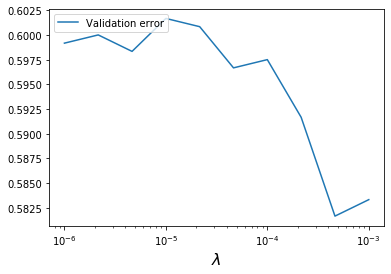

In [7]:
# Kernel Ridge Regression
TRIALS = 10
lambda_vals = np.logspace(-6, -3, TRIALS)

n = feats_train.shape[0]
d = feats_train.shape[1]
print(n)
K = feats_train @ feats_train.T 
intermediate = feats_train @ feats_val.T 
# print(labels_train.shape)
val_error = []
for lambd in lambda_vals:
    alpha = np.linalg.inv(K + lambd * n * np.eye(n))@labels_train
    pred = np.einsum('i, ij->j', alpha, intermediate)
    val_error.append(1-(np.sum(np.sign(pred) != np.sign(labels_val))/labels_val.shape))
    
plt.plot(lambda_vals, val_error, label="Validation error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

In [8]:
# Optimal lambda is around 9x10^-4 for linear kernel
lambd = 9*10**-4
K = feats_train @ feats_train.T 
intermediate = feats_train @ feats_test.T 
alpha = np.linalg.inv(K + lambd * n * np.eye(n))@labels_train
pred = np.einsum('i, ij->j', alpha, intermediate)

In [10]:
## SVM 
import cvxpy as cp

n = 1000
K = feats_train[:n] @ feats_train[:n].T
print(K.shape)
y = labels_train[:n]
intermediate = feats_train[:n] @ feats_val.T 

TRIALS = 10
lambda_vals = np.logspace(-7, -4, TRIALS)
val_error = []
for lambd in lambda_vals:
    alpha = cp.Variable(n)

    constraints = []
    for i in range(n):
        constraints += [y[i] * alpha[i] >=0 , y[i] * alpha[i] <= 1/(2*lambd*n)]

    prob = cp.Problem(cp.Minimize(-2 * alpha.T @ y + cp.quad_form(alpha, K) ), constraints)
    prob.solve()
    
    pred = np.einsum('i, ij->j', alpha.value, intermediate)
    val_error.append(1-(np.sum(np.sign(pred) != np.sign(labels_val))/labels_val.shape))

(1000, 1000)


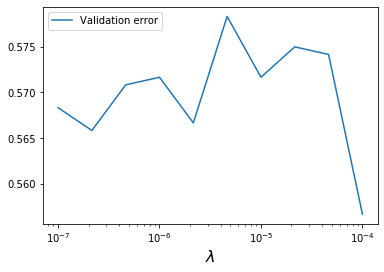

In [11]:
plt.plot(lambda_vals, val_error, label="Validation error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

In [12]:
print(labels_train)

[-1 -1 -1 ...  1 -1  1]


In [13]:
intermediate = feats_train[:n] @ feats_val.T 
pred = np.einsum('i, ij->j', alpha.value, intermediate)
print(pred)
labels_val[labels_val == 0] = -1
print(1-(np.sum(np.sign(pred) != np.sign(labels_val))/labels_val.shape))

[-0.35418174 -0.10007602 -0.12721142 ...  0.13391924  0.07042585
  0.20681735]
[0.55666667]


In [ ]:
def parse_output(predictions, filename):
    '''
        predictions : list of predictions
    '''
    predictions = np.sign(predictions)
    predictions[predictions == -1] = 0
    
    with open(filename, 'w') as f:
        f.write("Id,Bound\n")
        count = 0
        for i in range(predictions.shape[0]):
            f.write("{},{}\n".format(count, int(predictions[i])))
            count += 1
                

In [ ]:
parse_output(pred, "test.txt")

In [ ]:
np.sign(pred)

In [ ]:
def gaussian_kernel(feats, sigma=10):
    norm_feats  = np.sum(feats**2,1)
    print(norm_feats)
    K = np.exp(-(norm_feats[:,None] + norm_feats[None,:] - 2 * np.dot(norm_feats, norm_feats.T))/(2 * sigma** 2))
    return K

def gaussian_kernel_1d(feats,x, sigma=10):
    norm_x = np.square(np.linalg.norm(feats - x[None,:], axis=-1))
    K = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-norm_x/(2 * sigma** 2))
    return K
